In [1]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
W = 1000
H = 100
N = W * H
arr = torch.zeros(H, W, device=device, dtype=torch.float32)
arr[25:50, 25:50] = 10# + torch.rand(25, 25) * 10
arr[30:45, 30:45] = 30
arr[35:40, 35:40] = 50
arr[37:39, 37:39] = 60
arr

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

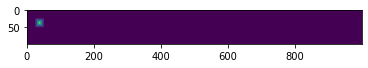

In [5]:
plt.imshow(arr.cpu().numpy())

In [6]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float32)

In [7]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:0'),
 torch.Size([4, 3, 3]))

In [8]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

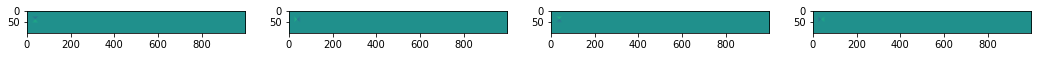

In [9]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [10]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [11]:
square, square.shape

(tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ...,

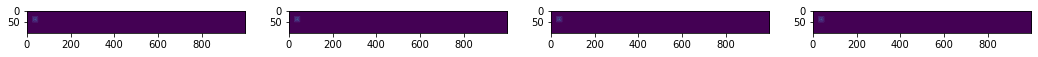

In [12]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [13]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [14]:
vertex_area = square.sum(axis=0)

In [15]:
vertex_area, vertex_area.shape

(tensor([[1.0000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.0000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         ...,
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.5000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 1.5000],
         [1.0000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.0000]],
        device='cuda:0'),
 torch.Size([100, 1000]))

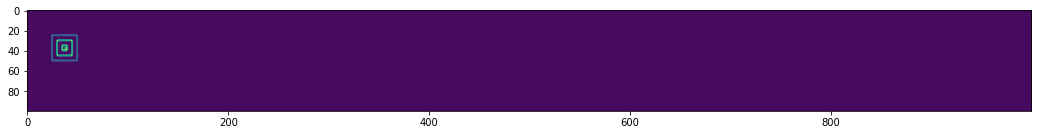

In [16]:
plt.imshow(vertex_area.cpu().numpy())

In [17]:
del square, arr
torch.cuda.empty_cache()

In [18]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [19]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N, device=device)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W, device=device)

In [20]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [21]:
# cu.cuda.Device(0).use()

main_v = cu.fromDlpack(to_dlpack(main_v))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [22]:
upper_m = scipy.sparse.coo_matrix((upper_edge_v / 2, (upper_edge_i, main_i[:-W])), shape=(N, N))
right_m = scipy.sparse.coo_matrix((right_edge_v / 2, (right_edge_i, right_edge_i + 1)), shape=(N, N))
down_m = scipy.sparse.coo_matrix((down_edge_v / 2, (down_edge_i, main_i[W:])), shape=(N, N))
left_m = scipy.sparse.coo_matrix((left_edge_v / 2, (left_edge_i, left_edge_i - 1)), shape=(N, N))
main_m = scipy.sparse.diags(-main_v / 2)

In [23]:
L = main_m + upper_m + right_m + down_m + left_m

In [24]:
M = scipy.sparse.diags(cu.fromDlpack(to_dlpack(vertex_area.view(-1) / 3)))

In [25]:
M.dtype, L.dtype

(dtype('float32'), dtype('float32'))

In [26]:
b = cu.zeros(N, dtype=cu.float32)
b[50 * W + 50] = 1
# b[3*W+20] = 1
b.dtype

dtype('float32')

In [27]:
del main_m, upper_m, right_m, down_m, left_m
del vertex_area
del main_v, main_i, upper_edge_v, upper_edge_i, right_edge_v, right_edge_i, down_edge_v, down_edge_i, left_edge_v, left_edge_i
torch.cuda.empty_cache()

11.790649175643921

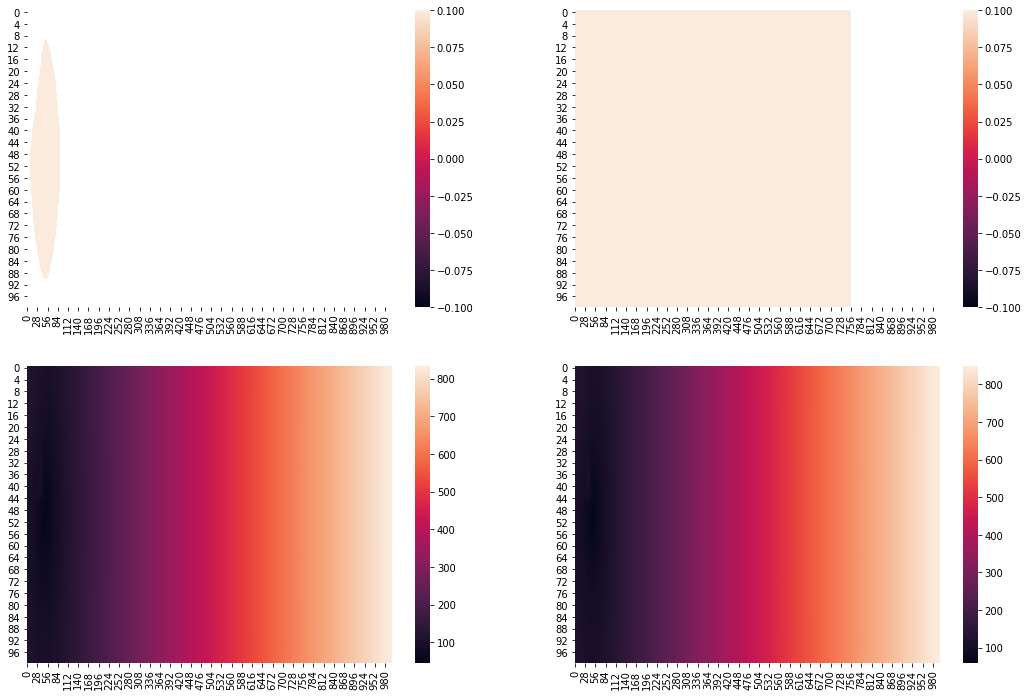

In [28]:
# u = scipy.sparse.linalg.lsqr(M - L, b)
# u = u[0]
start = time.time()
for i in range(4):
    t = (0.1 +  50 * i)
    u = scipy.sparse.linalg.lsqr(M - t * L, b)
    u = u[0]
    plt.subplot(2, 2, 1 + i)
    sns.heatmap(cu.asnumpy((-t ** 0.5 * cu.log(u)).reshape(H, W)))

end = time.time()
end - start
#     del u
#     torch.cuda.empty_cache()

In [29]:
(u == 0).sum(), u.shape[0]

(array(0), 100000)

In [30]:
# _ = plt.hist(cu.asnumpy(u.reshape(H, W).clip(0, 0.1)))

In [31]:
vectors = cu.fromDlpack(to_dlpack(vectors))
e1 = cu.zeros(shape=(3, H, W), dtype=cu.float32)
e2 = cu.zeros(shape=(3, H, W,), dtype=cu.float32)

e1[0, :, :] = -1
e1[2, :, :] = vectors[0]
e2[1:, :,] = 1
e2[2:, :,] = vectors[1]
cross_n1 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = 1
e1[2, :, :] = vectors[1]
e2[0:, :,] = 1
e2[2:, :,] = vectors[2]
cross_n2 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[0, :, :] = 1
e1[2, :, :] = vectors[2]
e2[1:, :,] = -1
e2[2:, :,] = vectors[3]
cross_n3 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = -1
e1[2, :, :] = vectors[3]
e2[0:, :,] = -1
e2[2:, :,] = vectors[0]
cross_n4 = cu.cross(e1, e2, axis=0)

In [32]:
cross_n = [cross_n1, cross_n2, cross_n3, cross_n4]

In [33]:
u = from_dlpack(u.toDlpack())
u = u.reshape(H, W)
vectors = from_dlpack(vectors.toDlpack())

In [43]:
def compute_gradient(kernel, u, cross_n, e1, e2, e3):
    u_ = torch.nn.functional.conv2d(input=u, weight=kernel, padding=1)[0]
    return u_[0] * torch.cross(cross_n, e1, dim=0) + u_[1] * torch.cross(cross_n, e2, dim=0) + u_[2] * torch.cross(cross_n, e3, dim=0)

In [44]:
gradients = []
kernels = [torch.tensor([[[0., 1., 0.], [0, 0, 0], [0, 0, 0]], 
                         [[0, 0, 0], [0., 0., 1.], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 1, 0], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0., 0., 0.], [0, 0, 1], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 0, 0], [0, 1, 0]], 
                         [[0, 0, 0], [0., 1., 0.], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0., 0., 0.], [0, 0, 0], [0, 1, 0]], 
                         [[0, 0, 0], [1., 0., 0.], [0, 0, 0]], 
                         [[0, 0, 0], [0., 1., 0.], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0, 0, 0], [1, 0, 0], [0., 0., 0.]], 
                         [[0, 1, 0], [0., 0., 0.], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 1, 0], [0, 0, 0]]], device=device, dtype=torch.float64),
          ]

# e1 = from_dlpack(e1.toDlpack())
# e2 = from_dlpack(e2.toDlpack())
# e3 = torch.zeros_like(e2)

index = {0:((-1, 0), (0, 1)) , 1: ((0, 1), (1, 0)), 2: ((1, 0), (0, -1)), 3: ((0, -1), (-1, 0))}

for i, cross_e in enumerate(cross_n):
    f_, s_ = index[i]
    e1[0, ...] = f_[0]
    e1[1, ...] = f_[1]
    e2[0, ...] = s_[0]
    e2[1, ...] = s_[1]
    e3[0, ...] = f_[0]
    e3[1, ...] = f_[1]
    
    e1[2] = -vectors[i % 4] + vectors[(i + 1) % 4]
    e2[2] = -vectors[(i + 1) % 4]
    e3[2] = -vectors[i % 4]
    gradients.append(compute_gradient(kernels[i][:, None], u[None, None], from_dlpack(cross_e.toDlpack()), e1, e2, e3))

In [57]:
gradients = [ -e / torch.norm(e, dim=0)[None] for e in gradients]

In [58]:
gradients[0]

tensor([[[-0.7075, -0.7083, -0.7090,  ..., -0.7044, -0.7059, -0.0000],
         [-0.4478, -0.4486, -0.4494,  ..., -0.4443, -0.4458, -0.0000],
         [-0.4482, -0.4490, -0.4498,  ..., -0.4443, -0.4458, -0.0000],
         ...,
         [-0.4467, -0.4476, -0.4484,  ..., -0.4447, -0.4462, -0.0000],
         [-0.4471, -0.4479, -0.4487,  ..., -0.4447, -0.4462, -0.0000],
         [-0.4475, -0.4483, -0.4491,  ..., -0.4447, -0.4462, -0.0000]],

        [[-0.7067, -0.7059, -0.7052,  ..., -0.7098, -0.7083, -1.0000],
         [-0.8941, -0.8937, -0.8933,  ..., -0.8959, -0.8951, -1.0000],
         [-0.8939, -0.8935, -0.8931,  ..., -0.8959, -0.8951, -1.0000],
         ...,
         [-0.8947, -0.8943, -0.8938,  ..., -0.8957, -0.8949, -1.0000],
         [-0.8945, -0.8941, -0.8937,  ..., -0.8957, -0.8949, -1.0000],
         [-0.8943, -0.8939, -0.8935,  ..., -0.8957, -0.8949, -1.0000]],

        [[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., -0